# ERA5 climate data tutorial

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

This notebook demonstrates how to access, analyze, simplify and visualize the [ERA5](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) dataset published by [ECMWF](https://www.ecmwf.int/), the leading European weather agency.

You will see how to:

* Download hourly temperature data from the Climate Data Store API
* Access and explore gridded data with the Python's xarray library
* Aggregate hourly data into daily readings
* Convert the agency's point-based data into squares for a map
* Smooth and simplify the data to make it easier to visualize

## Import Python tools

A few basic bits from the standard library

In [1]:
import os
from pathlib import Path
from urllib.request import urlopen

The ECMWF's API for its [Climate Data Store](https://cds.climate.copernicus.eu/)

In [2]:
import cdsapi

The [xarray](https://docs.xarray.dev/en/stable/index.html) tool for working with gridded data

In [3]:
import xarray as xr

[The National Science Foundation's special package](https://unidata.github.io/MetPy/latest/index.html) for fancy weather math

In [4]:
import metpy.calc as mpcalc

The typical Python tools for working with tabular data

In [5]:
import numpy as np
import pandas as pd

Geospatial tools for working with maps and GIS data

In [6]:
from shapely import Polygon
import geopandas as gpd

A minor formatting make our numbers easier to read

In [7]:
pd.options.display.float_format = "{:20,.2f}".format

## Download hourly climate data

Connect to the Climate Data Store API using our private key

In [10]:
c = cdsapi.Client(
    key=os.getenv("CDS_API_KEY"),
    url="https://cds.climate.copernicus.eu/api",
)

2025-02-03 15:32:00,326 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:32:00,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Download the hourly temperature data (known as 2t or t2m) for the provided date

In [11]:
def download_hourly_data(date: str, variable: str) -> Path:
    """Download the hourly ERA5 data for the provided date and variable.

    Args:
        date (str): The date to download for in YYYY-MM-DD format
        variable (str): The ERA5 variable to download

    Returns:
        The file Path to the downloaded file
    """
    r = c.retrieve(
        # The standard hourly data service
        # https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview
        "reanalysis-era5-single-levels",
        {
            "variable": variable,
            "product_type": "reanalysis",  # The sturdy dataset that takes five days to calculate
            "date": date,
            "time": [f"{str(i).zfill(2)}:00" for i in range(0, 24)],  # Get all 24 hours
            "format": "netcdf",  # The file format we prefer
        },
    )
    file_path = Path(f"./data/era5-{date}-{variable}.netcdf")
    with urlopen(r.location) as f, open(file_path, "wb") as b:
        b.write(f.read())
    return file_path

In [12]:
hourly_path = download_hourly_data("1982-07-22", "2t")

2025-02-03 15:32:01,047 INFO Request ID is 95d9bbe2-fd0c-4ca7-8984-d36f08b0a88a
2025-02-03 15:32:01,288 INFO status has been updated to accepted
2025-02-03 15:32:10,599 INFO status has been updated to running
2025-02-03 15:32:15,783 INFO status has been updated to successful


## Access and explore
Read in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) file, which is an special data format that science people use for gridded data. The typical tool for working with it is xarray.

In [13]:
ds = xr.open_dataset(hourly_path)

Take a peek at what's in there.

In [14]:
ds

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 24, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 192B 1982-07-22 ... 1982-07-22T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 384B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 100MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-03T16:35 GRIB to CDM+CF via cfgrib-0.9.1...

Don't worry. You can switch it to a standard DataFrame.

In [15]:
df = ds.to_dataframe()

And that's what you might expect.

In [16]:
df.head()

number expver                  t2m
valid_time latitude longitude                                    
1982-07-22 90.00    0.00            0   0001               274.17
                    0.25            0   0001               274.17
                    0.50            0   0001               274.17
                    0.75            0   0001               274.17
                    1.00            0   0001               274.17

Everything is grouped by the centroids of 1,000,000 grid squares that are 0.25 decimal degrees on each side.

You can reset it into a flat table the standard pandas way, reset_index.

In [17]:
df = df.reset_index()

In [18]:
df.head()

,valid_time,latitude,longitude,number,expver,t2m
0,1982-07-22,90.00,0.00,0,0001,274.17
1,1982-07-22,90.00,0.25,0,0001,274.17
2,1982-07-22,90.00,0.50,0,0001,274.17
3,1982-07-22,90.00,0.75,0,0001,274.17
4,1982-07-22,90.00,1.00,0,0001,274.17


What's up with that temperature data? Those numbers are really big!

<Axes: >

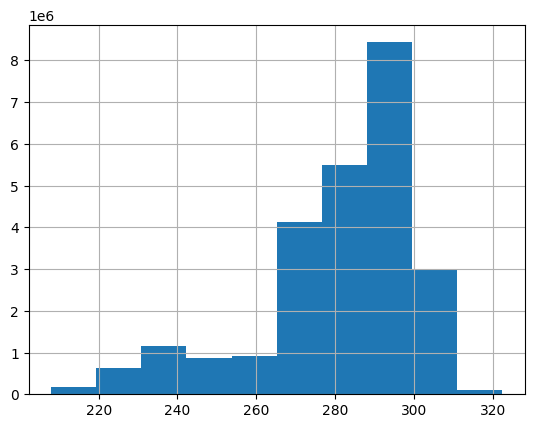

In [19]:
df.t2m.hist()

Oh. They're in [Kelvin](https://en.wikipedia.org/wiki/Kelvin). You might want to convert to something we're used to, like Celsius.

In [20]:
df["t2m"] = df["t2m"] - 273.15

Look. Much better.

<Axes: >

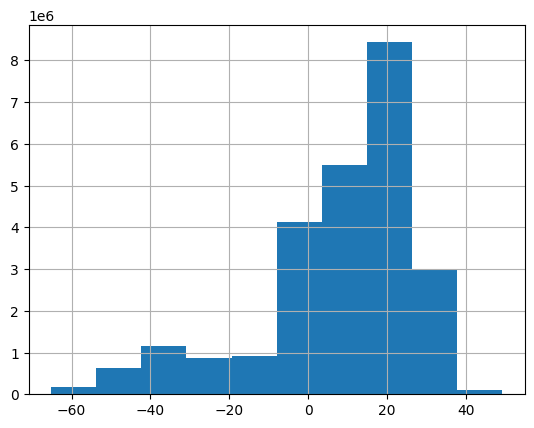

In [21]:
df.t2m.hist()

What's up with that valid time column?

In [22]:
df.valid_time.value_counts().reset_index()

,valid_time,count
0,1982-07-22 00:00:00,1038240
1,1982-07-22 01:00:00,1038240
2,1982-07-22 02:00:00,1038240
3,1982-07-22 03:00:00,1038240
4,1982-07-22 04:00:00,1038240
5,1982-07-22 05:00:00,1038240
6,1982-07-22 06:00:00,1038240
7,1982-07-22 07:00:00,1038240
8,1982-07-22 08:00:00,1038240
9,1982-07-22 09:00:00,1038240


## Aggregate

It's hourly. So, as you'd expect, there are 24 rows. To get the daily high, low and average temperature, you can group and aggregate the data using pandas' standard techniques.

In [23]:
daily_ranges = (
    df.groupby(["longitude", "latitude"])
    .agg({"t2m": ["min", "mean", "max", "count"]})
    .reset_index()
)

In [24]:
daily_ranges.head()

longitude             latitude                  t2m  \
                                                             min   
0                 0.00               -90.00               -39.20   
1                 0.00               -89.75               -39.02   
2                 0.00               -89.50               -39.15   
3                 0.00               -89.25               -38.89   
4                 0.00               -89.00               -39.14   

                                                   
                  mean                  max count  
0               -37.74               -36.77    24  
1               -37.47               -36.60    24  
2               -37.35               -36.31    24  
3               -37.01               -35.79    24  
4               -36.87               -35.54    24

It might be nice to clean up those columns, like so:

In [25]:
daily_ranges.columns = [
    "longitude",
    "latitude",
    "t2m_min",
    "t2m_mean",
    "t2m_max",
    "n",
]

## Gridding

Let's take a look at those centroids.

In [26]:
daily_ranges.head()

,longitude,latitude,t2m_min,t2m_mean,t2m_max,n
0,0.00,-90.00,-39.20,-37.74,-36.77,24
1,0.00,-89.75,-39.02,-37.47,-36.60,24
2,0.00,-89.50,-39.15,-37.35,-36.31,24
3,0.00,-89.25,-38.89,-37.01,-35.79,24
4,0.00,-89.00,-39.14,-36.87,-35.54,24


In [27]:
daily_ranges.tail()

,longitude,latitude,t2m_min,t2m_mean,t2m_max,n
1038235,359.75,89.00,0.36,0.63,0.96,24
1038236,359.75,89.25,0.37,0.60,0.94,24
1038237,359.75,89.50,0.38,0.58,0.89,24
1038238,359.75,89.75,0.38,0.59,0.88,24
1038239,359.75,90.00,0.43,0.72,1.02,24


Wait a minute. What's up with the longitude column? We typically don't map from 0-360. We map from -180 to 180 with the prime meridian set to zero in Greenwich.

That's not what's going on here.

In [28]:
daily_ranges.longitude.describe()

count           1,038,240.00
mean                  179.88
std                   103.92
min                     0.00
25%                    89.94
50%                   179.88
75%                   269.81
max                   359.75
Name: longitude, dtype: float64

So we need to convert it something our mapping tools will know how to use. Here's a trick.

In [29]:
def convert_longitude_to_180_scale(x: float | int) -> float | int:
    """Convert longitude values that run on 0-360 scale to a -180-180 scale.

    Based on instructions published by the ECWMF at https://confluence.ecmwf.int/pages/viewpage.action?pageId=149337515

    Args:
        x (float | int): A longitude value on a scale that runs from 0-360.

    Returns:
        The value converted to a -180-180 scale.

    Examples:
        >>> convert_longitude_to_180_scale(0)
        0
        >>> convert_longitude_to_180_scale(180)
        180
        >>> convert_longitude_to_180_scale(181)
        -179
        >> convert_longitude_to_180_scale(360)
        0
    """
    return x - 360 if x > 180 else x

In [30]:
daily_ranges["longitude"] = daily_ranges.longitude.apply(convert_longitude_to_180_scale)

Okay, that's cool, but we want to map squares, not centroid dots, so we need to convert those coordinate pairs to polygons.

First we generate a blank grid.

In [31]:
def create_polygon(x: float, y: float, width: float) -> Polygon:
    """Convert the provided centroid into a polygon using the provided width.

    Parameters
    ----------
    x : float
        The longitude centroid.
    y : float
        The latitude centroid.
    width : float
        The width of the polygon in degrees.

    Returns
    -------
    Polygon
        The polygon.

    Examples
    --------
    >>> create_polygon(0, 0, 1)
    POLYGON ((-0.5 0.5, 0.5 0.5, 0.5 -0.5, -0.5 -0.5, -0.5 0.5))
    """
    half = width * 0.5
    return Polygon(
        [
            [x - half, y + half],  # Upper left
            [x + half, y + half],  # Upper right
            [x + half, y - half],  # Lower right
            [x - half, y - half],  # Lower left
            [x - half, y + half],  # Upper left
        ]
    )

In [32]:
def get_grid_gdf(resolution_target: float = 0.25) -> gpd.GeoDataFrame:
    """Create a geospatial grid using the source latitude and longitude centroids.

    Args:
        resolution_target (float): The target resolution to regrid to. The default is 0.25, which matches the climatology.

    Returns:
        A geodataframe with the grid.
    """
    # Set the range for our target resolution, which is the whole planet
    longitude_range = np.arange(
        -180 + resolution_target,  # The minimum longitude
        180
        + resolution_target,  # The maximum longitude, plus the target resolution, so that the maximum longitude is included
        resolution_target,  # The target resolution, which is how far apart each point should be
    )
    latitude_range = np.arange(
        -90,  # The minimum latitude
        90
        + resolution_target,  # The maximum latitude, plus the target resolution again.
        resolution_target,  # You get the idea by now
    )

    # Combine them into a 2 dimensional grid that contains
    # every combination of latitude and longitude
    longitude_target, latitude_target = np.meshgrid(longitude_range, latitude_range)

    # Create a new dataframe with the target latitude and longitude
    # columns, and the columns we want to regrid
    df = pd.DataFrame(
        {
            "longitude": longitude_target.ravel(),
            "latitude": latitude_target.ravel(),
        }
    )

    # Convert the centroids to grid cells
    df["geometry"] = df.apply(
        lambda row: create_polygon(x=row.longitude, y=row.latitude, width=0.25),
        axis=1,
    )

    # Convert the dataframe into a geodataframe
    gdf = gpd.GeoDataFrame(df, geometry="geometry")

    # Return it
    return gdf

In [33]:
grid_gdf = get_grid_gdf()

Then we merge it to our daily aggregates using the coordinate pairs.

In [34]:
merged_df = pd.merge(daily_ranges, grid_gdf, on=["longitude", "latitude"], how="right")

That needs to be converted to a GeoDataFrame for Python to have GIS powers.

In [35]:
merged_gdf = gpd.GeoDataFrame(merged_df)

Let's take a little peek.

<Axes: >

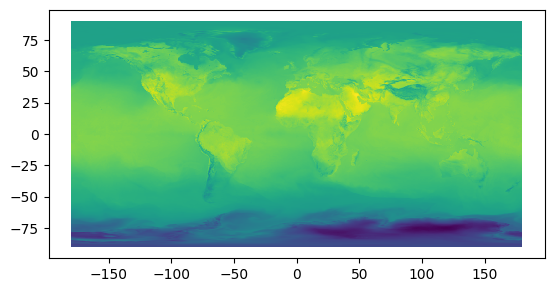

In [36]:
merged_gdf.plot("t2m_max", cmap="viridis")

## Smoothing

We can use a statistic method developed by the NSF to smooth out differences among neighboring squares.

First we trim down the dataframe to the variable we care about. Let's do high temperature.

In [37]:
trimmed_df = daily_ranges[["longitude", "latitude", "t2m_max"]].copy()

Convert that back into xarray, which is what metpy expects. Remember this is their thing.

In [38]:
trimmed_ds = trimmed_df.set_index(["longitude", "latitude"]).to_xarray()

Preprocess the data [the metpy way](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#units)

In [39]:
data = trimmed_ds["t2m_max"].metpy.quantify()

Smooth the variable using [one of the textbook methods](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.smooth_gaussian.html) and a common input option

In [40]:
degree_of_filtering = 10
smoothed = mpcalc.smooth_gaussian(data, degree_of_filtering)

Add the result back to the dataset

In [41]:
trimmed_ds["smoothed"] = (("longitude", "latitude"), smoothed.data.magnitude)

Convert that back to a DataFrame

In [42]:
smoothed_df = trimmed_ds.to_dataframe().reset_index()

In [43]:
smoothed_df.head()

,longitude,latitude,t2m_max,smoothed
0,-179.75,-90.00,-36.77,-37.25
1,-179.75,-89.75,-37.33,-37.51
2,-179.75,-89.50,-37.89,-37.98
3,-179.75,-89.25,-38.45,-38.55
4,-179.75,-89.00,-39.23,-39.12


Merge the geometries back on. We lose them along the way.

In [48]:
merged_gdf = gpd.GeoDataFrame(
    pd.merge(smoothed_df, grid_gdf, on=["longitude", "latitude"], how="right")
)

<Axes: >

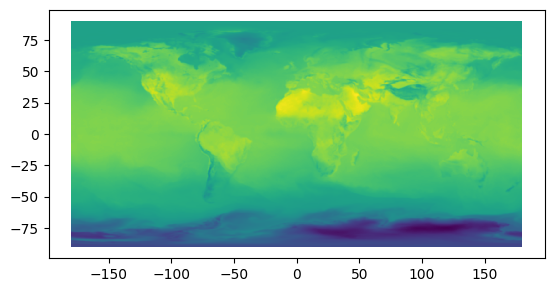

In [88]:
merged_gdf.plot("smoothed", cmap="viridis")

## Dissolving

That's awesome, but it will still take forever to run because we are mapping 1 million squares.

We can address that a couple ways, one is to round our data to the nearest digit and bin them.

In [49]:
merged_gdf["t2m_max_bin"] = np.copysign(
    np.ceil(np.abs(merged_gdf["smoothed"])), merged_gdf["smoothed"]
)

Let's have a look at that.

In [53]:
merged_gdf

,longitude,latitude,t2m_max,smoothed,geometry,t2m_max_bin
0,-179.75,-90.00,-36.77,-37.25,"POLYGON ((-179.875 -89.875, -179.625 -89.875, ...",-38.00
1,-179.50,-90.00,-36.77,-37.25,"POLYGON ((-179.625 -89.875, -179.375 -89.875, ...",-38.00
2,-179.25,-90.00,-36.77,-37.25,"POLYGON ((-179.375 -89.875, -179.125 -89.875, ...",-38.00
3,-179.00,-90.00,-36.77,-37.25,"POLYGON ((-179.125 -89.875, -178.875 -89.875, ...",-38.00
4,-178.75,-90.00,-36.77,-37.25,"POLYGON ((-178.875 -89.875, -178.625 -89.875, ...",-38.00
...,...,...,...,...,...,...
1038235,179.00,90.00,1.02,0.99,"POLYGON ((178.875 90.125, 179.125 90.125, 179....",1.00
1038236,179.25,90.00,1.02,0.99,"POLYGON ((179.125 90.125, 179.375 90.125, 179....",1.00
1038237,179.50,90.00,1.02,0.99,"POLYGON ((179.375 90.125, 179.625 90.125, 179....",1.00
1038238,179.75,90.00,1.02,0.99,"POLYGON ((179.625 90.125, 179.875 90.125, 179....",1.00


And now we dissolve the polygons.

In [54]:
dissolved = merged_gdf.dissolve("t2m_max_bin").reset_index()[
    ["t2m_max_bin", "geometry"]
]

In [55]:
dissolved

,t2m_max_bin,geometry
0,-62.00,"POLYGON ((117.125 -75.375, 116.875 -75.375, 11..."
1,-61.00,"POLYGON ((112.375 -75.625, 112.125 -75.625, 11..."
2,-60.00,"POLYGON ((94.625 -76.125, 94.375 -76.125, 94.1..."
3,-59.00,"POLYGON ((92.625 -76.625, 92.375 -76.625, 92.1..."
4,-58.00,"MULTIPOLYGON (((90.125 -76.875, 89.875 -76.875..."
...,...,...
106,45.00,"MULTIPOLYGON (((-14.125 19.125, -14.125 19.375..."
107,46.00,"MULTIPOLYGON (((-14.375 20.625, -14.375 20.875..."
108,47.00,"MULTIPOLYGON (((-13.875 22.125, -13.625 22.125..."
109,48.00,"MULTIPOLYGON (((46.125 30.875, 46.125 31.125, ..."


In [57]:
dissolved.to_file("./data/era5-dissolved.geojson", driver="GeoJSON")

/home/palewire/Code/era5-climate-data-example/.venv/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Now you're ready to open it up in QGIS!

<img src="./data/qgis.png" />